In [1]:
# necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import neattext.functions as nfx
import itertools
import collections
import nltk
from nltk import bigrams, trigrams 
from nltk.corpus import stopwords
stopwords = nltk.corpus.stopwords.words('english')

# ML packages
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score, recall_score

In [2]:
# Load dataset
df = pd.read_csv('data/covid_vaccine_tweets_data.csv', encoding='latin-1')

In [3]:
df['label'].value_counts()

1    10519
0     4720
Name: label, dtype: int64

#### Exploratory Data Analysis

* Word Counts

Text(0.5, 1.0, 'Distribution of Words in Tweets')

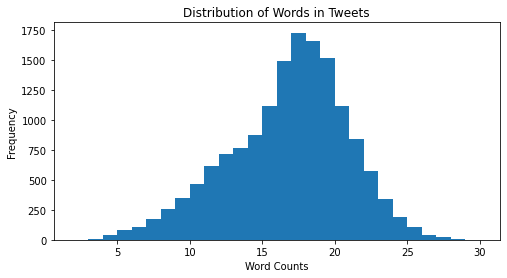

In [4]:
df['word_counts'] = df['text'].apply(lambda x: len(str(x).split()))
df['word_counts'].plot.hist(bins=28,figsize=(8,4))
plt.xlabel('Word Counts')
plt.ylabel('Frequency')
plt.title('Distribution of Words in Tweets')

* Text Length

<AxesSubplot:title={'center':'Distribution of Characters in Tweets'}, xlabel='Character Counts', ylabel='Frequency'>

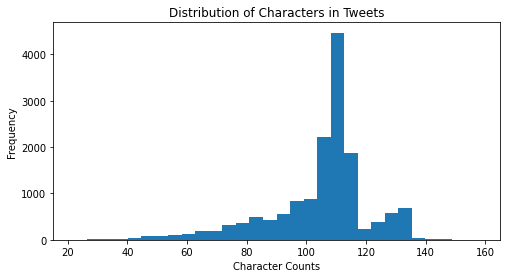

In [5]:
df['Tweets_length'] = df['text'].str.len()
plt.figure(figsize=(8,5))
plt.xlabel('Character Counts')
plt.ylabel('Frequency')
plt.title('Distribution of Characters in Tweets')
df['Tweets_length'].plot.hist(bins=30,figsize=(8,4))

* N-Gram Representations

In [6]:
# Remove stopwords and some keywords
stopwords.append('amp')
#stopwords.append('people')
#stopwords.append('minister')
stopwords.append('https')
#stopwords.append('dr')
stopwords.append('coronavirus')
stopwords.append('covid19vaccine')
stopwords.append('covidvaccine')
stopwords.append('covid19')
stopwords.append('covid')
stopwords.append('day')
stopwords.append('today')
stopwords.append('india')
stopwords.append('say')
stopwords.append('time')
stopwords.append('president')
stopwords.append('us')
stopwords.append('got')

In [7]:
words = [text.lower().split() for text in df['text']]

# remove stopwords from all tweets 
text_nsw = [[w for w in tweet_words if not w in stopwords]
                     for tweet_words in words]

# flatten your list and create a counter to return the most commonly used words
all_words_nsw = list(itertools.chain(*text_nsw))
counts_nsw = collections.Counter(all_words_nsw)
# dataframe for most common words
unigram_df = pd.DataFrame(counts_nsw.most_common(20), columns=['unigram','count'])


# Create list of lists containing bigrams in tweets
terms_bigram = [list(bigrams(text)) for text in text_nsw]
# Flatten list of bigrams in clean tweets
bigrams = list(itertools.chain(*terms_bigram))
# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams)
# create pandas dataframe
bigram_df = pd.DataFrame(bigram_counts.most_common(20), columns=['bigram', 'count'])

# Create list of lists containing trigrams in tweets
terms_trigram = [list(trigrams(text)) for text in text_nsw]
# Flatten list of trigrams in clean tweets
trigrams = list(itertools.chain(*terms_trigram))
# Create counter of words in clean trigrams
trigram_counts = collections.Counter(trigrams)
# create pandas dataframe
trigram_df = pd.DataFrame(trigram_counts.most_common(20), columns=['trigram', 'count'])

pd.concat([unigram_df,bigram_df,trigram_df], axis=1)

,unigram,count,bigram,count,trigram,count
0,vaccine,4048,"(first, dose)",243,"(received, first, dose)",59
1,httpst,1877,"(side, effects)",209,"(first, dose, vaccine)",46
2,get,1205,"(get, vaccine)",176,"(vaccine, immunity, duration)",27
3,first,1124,"(vaccination, drive)",138,"(vaccine, side, effects)",26
4,vaccination,992,"(second, dose)",135,"(worlds, largest, vaccination)",22
5,vaccines,860,"(moderna, vaccine)",133,"(moderna, pfizer, vaccines)",22
6,people,774,"(received, first)",117,"(largest, vaccination, drive)",22
7,dose,734,"(get, vaccinated)",110,"(dose, moderna, vaccine)",21
8,health,691,"(million, doses)",102,"(first, consignment, covishield)",21
9,doses,620,"(pfizer, vaccine)",98,"(one, step, closer)",19


#### Machine Learning Classifiers

* Data Clearning and Preprocessing

In [8]:
# convert text to lowercase
df = df.apply(lambda x: x.astype(str).str.lower())

In [9]:
# remove stopwords and other irrelevant characters
df['clean_text'] = df['text'].apply(nfx.remove_stopwords)
df['clean_text'] = df['clean_text'].apply(nfx.remove_userhandles) 
df['clean_text'] = df['clean_text'].apply(nfx.remove_special_characters)
df['clean_text'] = df['clean_text'].apply(nfx.remove_punctuations)
df['clean_text'] = df['clean_text'].apply(nfx.remove_numbers)
df['clean_text'] = df['clean_text'].apply(nfx.remove_hashtags)
df['clean_text'] = df['clean_text'].apply(nfx.fix_contractions)

* Features, Labels, Train_Test Split, and Vectorization

In [10]:
# Features and Labels
X = df['clean_text']
y = df['label']

In [11]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

vectorizer = TfidfVectorizer(ngram_range=(1,2)) 
X_train_tfidf = vectorizer.fit_transform(X_train)

* SVM Classifier

In [12]:
svm_clf = LinearSVC()
# fit it to the vectorize training data
svm_clf.fit(X_train_tfidf, y_train)

# combine vectorization of train and test sets into one pipeline
svm_clf = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,2))),('svm_clf', LinearSVC())])
# fit the original train and test sets data
svm_clf.fit(X_train, y_train)

# test classifier and display result
svm_pred = svm_clf.predict(X_test)

# Evaluation Metrics
# 'weighted' takes care of inbalance labels
print('Accuracy: {:.4f}'.format(accuracy_score(y_test, svm_pred)))
print('Precision: {:.4f}'.format(precision_score(y_test, svm_pred, average='weighted')))
print('Recall: {:.4f}'.format(recall_score(y_test, svm_pred, average='weighted')))
print('F1: {:.4f}'.format(f1_score(y_test, svm_pred, average='weighted')))

Accuracy: 0.8432
Precision: 0.8432
Recall: 0.8432
F1: 0.8350


In [13]:
# save the model
import pickle
with open('svm_model','wb') as file:
    pickle.dump(svm_clf,file)

In [14]:
# load model and make prediction
with open('svm_model','rb') as file:
    svm_model = pickle.load(file)

In [15]:
result = svm_model.score(X_test,y_test)
print(result)

0.8431758530183727


* Logistic Regression Classifier

In [16]:
lr_clf = LogisticRegression()
# fit it to the vectorize training data
lr_clf.fit(X_train_tfidf, y_train)

# combine vectorization of train and test sets into one pipeline
lr_clf = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,2))),('lr_clf', LogisticRegression())])
# fit the original train and test sets data
lr_clf.fit(X_train, y_train)

# test classifier and display result
lr_pred = lr_clf.predict(X_test)

# Evaluation Metrics
# 'weighted' takes care of inbalance labels
print('Accuracy: {:.4f}'.format(accuracy_score(y_test, lr_pred)))
print('Precision: {:.4f}'.format(precision_score(y_test, lr_pred, average='weighted')))
print('Recall: {:.4f}'.format(recall_score(y_test, lr_pred, average='weighted')))
print('F1: {:.4f}'.format(f1_score(y_test, lr_pred, average='weighted')))

Accuracy: 0.8274
Precision: 0.8504
Recall: 0.8274
F1: 0.8068


In [17]:
# save the model
with open('lr_model','wb') as file:
    pickle.dump(lr_clf,file)

* Multinomial Naive Bayes

In [18]:
nb_clf = MultinomialNB()

# fit it to the vectorize training data
nb_clf.fit(X_train_tfidf, y_train)

# combine vectorization of train and test sets into one pipeline
nb_clf = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,2))),('nb_clf', MultinomialNB())])
# fit the original train and test sets data
nb_clf.fit(X_train, y_train)

# test classifier and display result
nb_pred = nb_clf.predict(X_test)

# Evaluation Metrics
# 'weighted' takes care of inbalance labels
print('Accuracy: {:.4f}'.format(accuracy_score(y_test, nb_pred)))
print('Precision: {:.4f}'.format(precision_score(y_test, nb_pred, average='weighted')))
print('Recall: {:.4f}'.format(recall_score(y_test, nb_pred, average='weighted')))
print('F1: {:.4f}'.format(f1_score(y_test, nb_pred, average='weighted')))

Accuracy: 0.7741
Precision: 0.8283
Recall: 0.7741
F1: 0.7254


In [19]:
# save the model
with open('nb_model','wb') as file:
    pickle.dump(nb_clf,file)

* Random Forest Classifier

In [20]:
rf_clf = RandomForestClassifier(n_jobs=-1)

# fit it to the vectorize training data
rf_clf.fit(X_train_tfidf, y_train)

# combine vectorization of train and test sets into one pipeline
rf_clf = Pipeline([('tfidf', TfidfVectorizer()),('rf_clf', RandomForestClassifier(n_jobs=-1))])
# fit the original train and test sets data
rf_clf.fit(X_train, y_train)

# test classifier and display result
rf_pred = rf_clf.predict(X_test)

# Evaluation Metrics
# 'weighted' takes care of inbalance labels
print('Accuracy: {:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('Precision: {:.4f}'.format(precision_score(y_test, rf_pred, average='weighted')))
print('Recall: {:.4f}'.format(recall_score(y_test, rf_pred, average='weighted')))
print('F1: {:.4f}'.format(f1_score(y_test, rf_pred, average='weighted')))

Accuracy: 0.8307
Precision: 0.8430
Recall: 0.8307
F1: 0.8144


In [21]:
# save the model
with open('rf_model','wb') as file:
    pickle.dump(rf_clf,file)